In [2]:
from models import Tiny
from matplotlib import pyplot as plt
import cv2
import numpy as np
import torch

In [3]:
N_CLASSES = 80
MASK = [0, 1, 2]
ANCHORS = [(10, 14), (23, 27), (37, 58), (81, 82), (135, 169), (344, 319)]
HYPERPARAMS = {
    "batch_size": 1,
    "subdivisions": 1,
    "width": 416,
    "height": 416,
    "channels": 3,
    "momentum": 0.9,
    "decay": 0.0005,
    "angle": 0,
    "saturation": 1.5,
    "exposure": 1.5,
    "hue": 0.1
}

In [4]:
def load_img(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def to_variable(img):
    img = cv2.resize(img, (416, 416)).transpose((2, 0, 1))
    img = img[np.newaxis, ...] / 255.0
    img = torch.from_numpy(img).float()
    img = torch.autograd.Variable(img)
    return img

In [5]:
tiny = Tiny(N_CLASSES, MASK, ANCHORS, HYPERPARAMS)
tiny.load_weights("yolov3-tiny.weights")

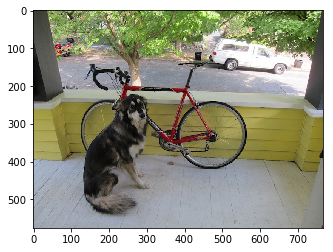

In [7]:
img = load_img("data/dog.jpg")
plt.imshow(img)
plt.show()

In [83]:
tiny.eval()
# with torch.no_grad():
predictions = tiny(to_variable(img))
for i in predictions:
    print(i.shape)
yl_16 = predictions[16]
yl_23 = predictions[23]
print(yl_16.shape)
print(yl_23.shape)

torch.Size([1, 16, 416, 416])
torch.Size([1, 16, 208, 208])
torch.Size([1, 32, 208, 208])
torch.Size([1, 32, 104, 104])
torch.Size([1, 64, 104, 104])
torch.Size([1, 64, 52, 52])
torch.Size([1, 128, 52, 52])
torch.Size([1, 128, 26, 26])
torch.Size([1, 256, 26, 26])
torch.Size([1, 256, 13, 13])
torch.Size([1, 512, 13, 13])
torch.Size([1, 512, 13, 13])
torch.Size([1, 1024, 13, 13])
torch.Size([1, 256, 13, 13])
torch.Size([1, 512, 13, 13])
torch.Size([1, 255, 13, 13])
torch.Size([1, 3, 13, 13, 85])
torch.Size([1, 256, 13, 13])
torch.Size([1, 128, 13, 13])
torch.Size([1, 128, 26, 26])
torch.Size([1, 384, 26, 26])
torch.Size([1, 256, 26, 26])
torch.Size([1, 255, 26, 26])
torch.Size([1, 3, 26, 26, 85])
torch.Size([1, 3, 13, 13, 85])
torch.Size([1, 3, 26, 26, 85])


C:\Program Files\Anaconda3\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


In [79]:
index2labels = {}
for i,j in enumerate(open("./coco_names.txt")):
    index2labels[i] = j

In [91]:
out = yl_16
size = out.size()
for i in range(size[2]):
    for j in range(size[3]):
        if out[0,0,i,j,4].item() > 0.3:
            probability, label = out[0,0,i,j,5:85].topk(1)
            if probability > 0.8:
                print(i,j,probability.item(),index2labels[label.item()])
                x,y,xmax,ymax = out[0,0,i,j,0:4]
                print(out[0,0,i,j,0:4].tolist())
                x = x.item() / 13 *416
                y = y.item() / 13 *416
                xmax = xmax.item()*416
                ymax = ymax.item()*416
                print(x,y,xmax,ymax)

3 8 0.818874716758728 car

[3.6569488048553467, 3.436079740524292, 0.5400439500808716, 0.40343502163887024]
117.0223617553711 109.95455169677734 224.65828323364258 167.82896900177002
3 9 0.8780291676521301 car

[3.752659320831299, 3.419222354888916, 0.4290815591812134, 0.4034820795059204]
120.08509826660155 109.41511535644531 178.49792861938477 167.8485450744629
3 10 0.913255512714386 car

[3.451059341430664, 3.428311824798584, 0.38115981221199036, 0.40483778715133667]
110.43389892578125 109.70597839355469 158.562481880188 168.41251945495605
6 2 0.8186245560646057 chair

[6.758543491363525, 6.840412139892578, 0.3106479048728943, 0.5382794141769409]
216.2733917236328 218.8931884765625 129.22952842712402 223.92423629760742
6 4 0.8949638605117798 dog

[6.58170747756958, 6.591009616851807, 0.3119014501571655, 0.48199695348739624]
210.61463928222656 210.91230773925784 129.75100326538086 200.51073265075684
7 1 0.8845139145851135 chair

[7.499159812927246, 7.484867572784424, 0.309725135564804

In [45]:
print(yl_16[0,0,10,3,5:85])

tensor([0.4911, 0.2788, 0.2982, 0.2719, 0.2992, 0.2368, 0.2776, 0.2542, 0.2817,
        0.2681, 0.2844, 0.2734, 0.2600, 0.2982, 0.3906, 0.4955, 0.4429, 0.3553,
        0.3398, 0.3497, 0.3166, 0.3797, 0.3129, 0.3190, 0.2944, 0.2963, 0.3414,
        0.3214, 0.2763, 0.2678, 0.3147, 0.3118, 0.2896, 0.2889, 0.2556, 0.2929,
        0.2961, 0.3084, 0.2492, 0.3501, 0.3293, 0.3167, 0.3227, 0.3070, 0.2914,
        0.3273, 0.3239, 0.3154, 0.3053, 0.2468, 0.3055, 0.2843, 0.2884, 0.3224,
        0.3173, 0.3096, 0.3489, 0.3640, 0.3361, 0.3667, 0.3122, 0.3346, 0.3029,
        0.3478, 0.3190, 0.3330, 0.3029, 0.3170, 0.2694, 0.2924, 0.2586, 0.3644,
        0.2902, 0.3628, 0.2675, 0.3134, 0.3379, 0.3917, 0.3078, 0.3403],
       grad_fn=<SliceBackward>)
